In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import joblib

In [21]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [2]:
meas_data = pd.read_excel('output.xlsx')
to_remove = ['Unnamed: 0', 'Phase 1 Forward active Energy kWh',
       'Phase 2 Forward active Energy kWh',
       'Phase 3 Forward active Energy kWh', 'suma', 'time']
meas_data.drop(to_remove, axis=1, inplace=True)

In [3]:
y = meas_data['usage']
X = meas_data[['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'wpgt', 'pres']]

In [4]:
def objective(trial):
    meas_data = pd.read_excel('output.xlsx')
    to_remove = ['Unnamed: 0', 'Phase 1 Forward active Energy kWh',
       'Phase 2 Forward active Energy kWh',
       'Phase 3 Forward active Energy kWh', 'suma', 'time']
    y = meas_data['usage']
    X = meas_data[['tavg', 'tmin', 'tmax','wdir', 'wspd', 'wpgt', 'pres']]
    train_x, valid_x, train_y, valid_y= train_test_split(X, y, test_size=0.15, random_state=222)
    
    dtrain = lgb.Dataset(train_x, train_y)

    param = {
        #"objective": "binary",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate",0,1),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 35),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    #pred_labels = np.rint(preds)
    mse = sklearn.metrics.mean_squared_error(valid_y, preds)
    return mse

In [5]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-02-20 11:24:46,981] A new study created in memory with name: no-name-3126f9cf-da11-40cd-8fbc-680d11abe03d
[I 2023-02-20 11:24:47,082] Trial 0 finished with value: 78.64536880567842 and parameters: {'learning_rate': 0.8255526684603167, 'lambda_l1': 7.757108034464845e-05, 'lambda_l2': 1.444902906043464e-07, 'num_leaves': 16, 'feature_fraction': 0.5071616612462546, 'bagging_fraction': 0.4506711160131961, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 0 with value: 78.64536880567842.
[I 2023-02-20 11:24:47,339] Trial 1 finished with value: 55.36111304544496 and parameters: {'learning_rate': 0.6172183686912605, 'lambda_l1': 0.135064838856348, 'lambda_l2': 6.393105791729494e-08, 'num_leaves': 4, 'feature_fraction': 0.7734215557423967, 'bagging_fraction': 0.8524809781859479, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 1 with value: 55.36111304544496.
[I 2023-02-20 11:24:47,429] Trial 2 finished with value: 841.7028397132143 and parameters: {'learning_rate': 0

Number of finished trials: 200
Best trial:
  Value: 10.022137522187187
  Params: 
    learning_rate: 0.08732149006494845
    lambda_l1: 0.034720436309541705
    lambda_l2: 6.759208687432269e-07
    num_leaves: 3
    feature_fraction: 0.8019341545935235
    bagging_fraction: 0.9456794883741091
    bagging_freq: 2
    min_child_samples: 5


In [6]:
model=lgb.LGBMRegressor(learning_rate=trial.params['learning_rate'], 
                        lambda_l1=trial.params['lambda_l1'],
                        lambda_l2= trial.params['lambda_l2'],
                        num_leaves= trial.params['num_leaves'],
                        feature_fraction= trial.params['feature_fraction'],
                        bagging_fraction=trial.params['bagging_fraction'], 
                        bagging_freq=trial.params['bagging_freq'],
                        min_child_samples=trial.params['min_child_samples'] )

model

LGBMRegressor(bagging_fraction=0.9456794883741091, bagging_freq=2,
              feature_fraction=0.8019341545935235,
              lambda_l1=0.034720436309541705, lambda_l2=6.759208687432269e-07,
              learning_rate=0.08732149006494845, min_child_samples=5,
              num_leaves=3)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60222)

In [8]:
model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8019341545935235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8019341545935235
[LightGBM] [Warning] lambda_l1 is set=0.034720436309541705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.034720436309541705
[LightGBM] [Warning] bagging_fraction is set=0.9456794883741091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9456794883741091
[LightGBM] [Warning] lambda_l2 is set=6.759208687432269e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.759208687432269e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


LGBMRegressor(bagging_fraction=0.9456794883741091, bagging_freq=2,
              feature_fraction=0.8019341545935235,
              lambda_l1=0.034720436309541705, lambda_l2=6.759208687432269e-07,
              learning_rate=0.08732149006494845, min_child_samples=5,
              num_leaves=3)

In [9]:
yy = model.predict(X)

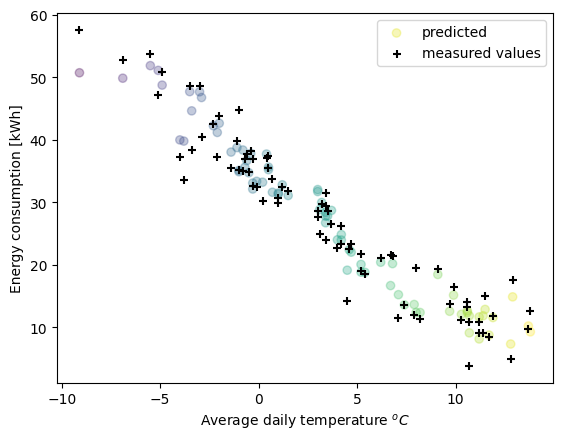

In [10]:
plt.scatter(X['tavg'],yy, label='predicted', c=X.iloc[:,0], marker='o',alpha=0.3)
plt.scatter(X['tavg'],y,label='measured values',c='black',marker='+',alpha=1)
plt.xlabel('Average daily temperature $^{o}C$')
plt.ylabel('Energy consumption [kWh]')
plt.legend()
plt.show()

In [28]:
round(rmse(y, yy),2)

2.92

In [29]:
joblib.dump(model, 'lgb_model.sav')

['lgb_model.sav']

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def dane_pogodowe():
    url = 'https://bulk.meteostat.net/v2/daily/12150.csv.gz'
    data = pd.read_csv(url, compression='gzip', header=0, sep=',')
    names=['time','tavg','tmin','tmax','prcp','snow','wdir','wspd','wpgt','pres','tsun']
    data_out=pd.DataFrame()
    for i in range(11):
        data_out[names[i]] = data.iloc[:,i]
    
    data_out['time'] = pd.to_datetime(data_out['time'])
    return data_out

consumption = pd.DataFrame()
data = dane_pogodowe()

years = data['time'].dt.year
year = years.unique()
usage=[]
yr=[]
for i in year:
    data_tmp = data.loc[data['time'].dt.year==i]
    data_tmp2 = data_tmp.loc[(data_tmp['time'].dt.month>=11)|(data_tmp['time'].dt.month<4)]
    #print (i)
    sh=data_tmp2.shape[0]
    #data_tmp2['usage']=3
    if sh>=120:
        print (i)
        XX=data_tmp2[['tavg', 'tmin', 'tmax','wdir', 'wspd', 'wpgt', 'pres']]
        result=model.predict(XX)
        value=result.sum()
        usage.append(value)
        yr.append(i)
consumption['yr']=yr
consumption['usage']=usage
 

2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


<BarContainer object of 16 artists>

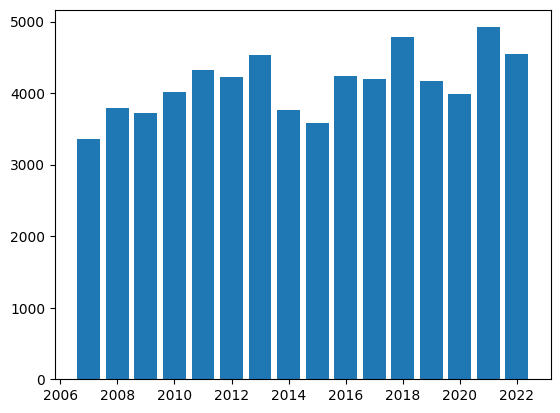

In [32]:
plt.bar(consumption['yr'],consumption['usage'])

In [33]:
consumption['usage'].describe()

count      16.000000
mean     4135.563267
std       430.012976
min      3362.848979
25%      3790.085418
50%      4187.269943
75%      4372.753201
max      4920.121317
Name: usage, dtype: float64

In [17]:
trial

FrozenTrial(number=75, state=TrialState.COMPLETE, values=[10.022137522187187], datetime_start=datetime.datetime(2023, 2, 20, 11, 24, 59, 337710), datetime_complete=datetime.datetime(2023, 2, 20, 11, 24, 59, 486012), params={'learning_rate': 0.08732149006494845, 'lambda_l1': 0.034720436309541705, 'lambda_l2': 6.759208687432269e-07, 'num_leaves': 3, 'feature_fraction': 0.8019341545935235, 'bagging_fraction': 0.9456794883741091, 'bagging_freq': 2, 'min_child_samples': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=35, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'b

In [ ]:
study.best_trial

FrozenTrial(number=186, values=[8.469312283243543], datetime_start=datetime.datetime(2023, 1, 28, 18, 30, 27, 133026), datetime_complete=datetime.datetime(2023, 1, 28, 18, 30, 27, 280027), params={'learning_rate': 0.10781862306176719, 'lambda_l1': 3.824690981272479e-07, 'lambda_l2': 5.330422564065671e-07, 'num_leaves': 13, 'feature_fraction': 0.583233596506808, 'bagging_fraction': 0.5864411307202623, 'bagging_freq': 2, 'min_child_samples': 9}, distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=35, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_sample